In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '56560b8e22d446c4afe0d3055fae3469')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
plant_types = 'succulent', 'cactus', 'tree'
path = Path('plants')

In [6]:
if not path.exists():
    path.mkdir()
    for o in plant_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://sixheartsonejourney.files.wordpress.com/2014/08/gg-rtw-mexico-cactus-plant.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p plants/cactus
$ cd plants/cactus
$ wget -c https://sixheartsonejourney.files.wordpress.com/2014/08/gg-rtw-mexico-cactus-plant.jpg
$ tar xf gg-rtw-mexico-cactus-plant.jpg
 And re-run your code once the download is successful



In [7]:
fns = get_image_files(path)
fns

(#431) [Path('plants/succulent/00000003.jpg'),Path('plants/succulent/00000006.jpg'),Path('plants/succulent/00000007.jpg'),Path('plants/succulent/00000000.jpeg'),Path('plants/succulent/00000004.jpg'),Path('plants/succulent/00000008.jpg'),Path('plants/succulent/00000010.jpg'),Path('plants/succulent/00000013.jpg'),Path('plants/succulent/00000012.jpg'),Path('plants/succulent/00000014.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#2) [Path('plants/cactus/00000054.jpg'),Path('plants/cactus/00000136.jpeg')]

In [9]:
failed.map(Path.unlink);

In [10]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = plants.dataloaders(path)

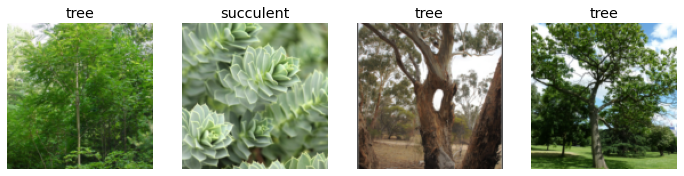

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

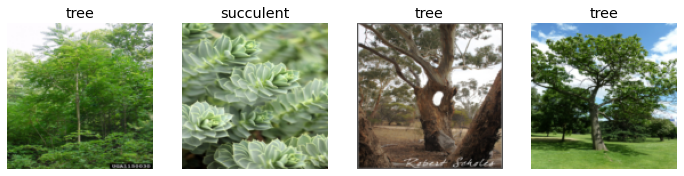

In [15]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

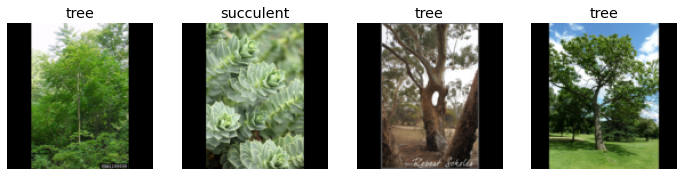

In [16]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

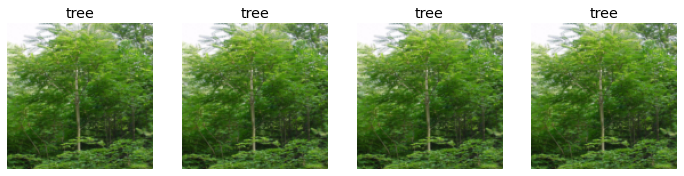

In [17]:
plants = plants.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

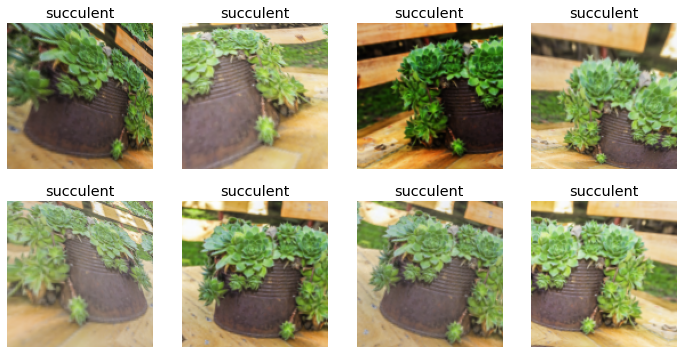

In [19]:
plants = plants.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [42]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=1),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

In [43]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.461255,0.501922,0.200000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.646229,0.473383,0.200000,00:09
1,0.527078,0.373482,0.094118,00:11
2,0.417211,0.307265,0.070588,00:10
3,0.328585,0.343554,0.058824,00:09
4,0.278147,0.428066,0.082353,00:10
5,0.231204,0.411040,0.058824,00:09
6,0.195686,0.375162,0.058824,00:10
7,0.169914,0.359140,0.058824,00:09
8,0.145511,0.348913,0.058824,00:10
9,0.131155,0.342655,0.058824,00:09


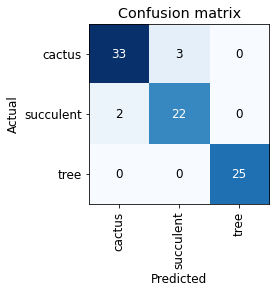

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

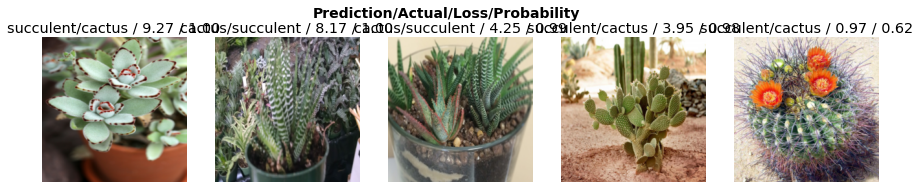

In [45]:
interp.plot_top_losses(5, nrows=1)

In [46]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [47]:
learn.export()

In [48]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [49]:
learn_inf = load_learner(path/'export.pkl')

In [50]:
learn_inf.dls.vocab

['cactus', 'succulent', 'tree']

In [51]:
btn_upload = widgets.FileUpload()

In [54]:
btn_run = widgets.Button(description='Classify')

In [63]:
img = PILImage.create(btn_upload.data[-1])

In [64]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [65]:
pred,pred_idx,probs = learn_inf.predict(img)

In [66]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: succulent; Probability: 1.0000')

In [67]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [68]:
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])